# Tutorial Part 1: Implementing a Variational Autoencoder
Inference combinators [(Stites and Zimmermann et al., 2021)](https://arxiv.org/abs/2103.00668) are a set of program transformations that allow us to compose probabilistic programs to implement importance-sampling-based inference algorithms.
We defer the introduction of the Coix API and semantics to the [second tutorial](./tutorial_part2_api.ipynb) and instead focus on showcasing some basic functionality of the Coix on a simple example, implementing a Variational Autoencoder (VAE).

### Variational Auto Encoders

VAEs are a simple framework, for learning a *deep latent variable model* (DLVM) $p_\theta(x, z) = p_\theta(x \mid z)p(z)$, which models the emergence of observed data $x \in X$ in terms of a generative process defined on latent variables $z \in Z$, together with a variational approximation $q_\phi(\cdot \mid x)$ to its posterior distribution $p_\theta(\cdot \mid x)$ [(Kingma et al.)](https://arxiv.org/abs/1312.6114). The model and variational approximation are trained jointly by maximizing the evidence lower bound (ELBO) on the log-marginal likelihood 

\begin{align}
\mathrm{ELBO}(\phi, \theta, x)
=
\mathbb{E}_{z \sim q_\phi(\cdot \mid x)}\left[
\log
\frac{ p_\theta(x, z) }{ q_\phi(z \mid x) }
\right]
=
\log p_\theta(x) 
- 
\mathrm{D}_\mathrm{KL}\left(q_\phi(\cdot \mid x)\ ||\ p_\theta(\cdot \mid x)\right)
\leq
\log p_\theta(x)
.
\end{align}

Maximizing the ELBO can be understood as (1) minimizing the reverse KL divergence between the variational approximation and the true posterior, while (2) simultaneously maximizing the log-marginal likelihood of the DLVM (under the constraint that the variational approximation stays close to the posterior).

#### Different terminology in different frameworks

- **Autoencoder view:** The process of generating a sample $z \sim q_\phi(\cdot \mid x)$ from the variational approximation conditioned on an observed data instance is also refered as encoding (a data point $x$ to latent code $z$), while *reconstructing* a data instance $\hat x \sim p_\theta(\cdot \mid z)$ from latent code $z$ is referred as decoding. 

- **Combinators view:** In the context of inference combinators and importance sampling we view $p_\theta(\cdot, x)$ as a unnormalized density on $Z$, for each $x \in X$, which we target in an importance sampling scheme that proposes samples from a variational proposal $q_\phi(z \mid x)$.

### Generating the Data

We first generate a simple toy data set by sampling $n_\mathrm{train} + n_\mathrm{test}$ data points from the two-moons density, which we will use to train and test our variational approximation respectively.

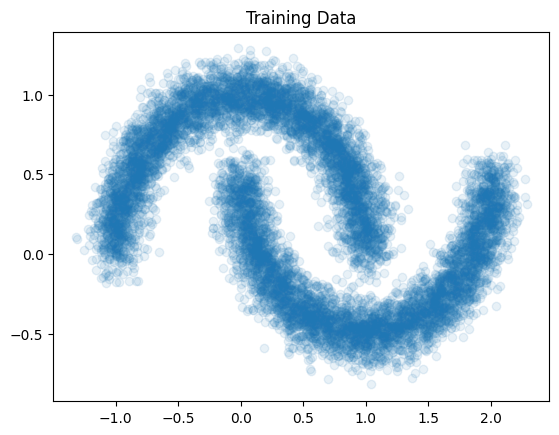

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

n_train, n_test = 10000, 3000
data_train, _ = make_moons(n_samples=n_train, shuffle=True, noise=0.1)
data_test, _ = make_moons(n_samples=n_test, shuffle=True, noise=0.1)
plt.title("Training Data")
plt.scatter(*data_train.T, alpha=0.1)

### Defining the model with probabilitic programs

We implement a prior, likelihood (a.k.a. decoder model), and variational proposal (a.k.a. encoder model), as probabilistic numpyro programs, which we can later compose using inference combinators. 
The encoder program and decoder program depend on an encoder function $f_\mathrm{enc}$ and decoder function $f_\mathrm{dev}$, which we implement as neural networks, with learnable parameters $\phi$ and $\theta$ respectively.

In [2]:
import numpyro
import numpyro.distributions as dist


def make_programs(f_enc, f_dec):
  # prior_program does not use x argument but needs to pass it on to dec_program
  def prior_program(params, x):
    z = numpyro.sample("z", dist.Normal(0, 1).expand((2,)).to_event(1))
    return (params, z, x)

  # arguments matche the output of prior_program
  def dec_program(params, z, x=None):
    _, dec_params = params
    mean_x = f_dec.apply(dec_params, z)
    x = numpyro.sample("x", dist.Normal(mean_x, 1.0).to_event(1), obs=x)
    return (mean_x, x)

  def enc_program(params, x):
    enc_params, _ = params
    mean_z = f_enc.apply(enc_params, x)
    z = numpyro.sample("z", dist.Normal(mean_z, 0.01).to_event(1))
    return (mean_z, z)

  return prior_program, enc_program, dec_program

We define the neural networks as simple Multilayer Perceptrons (MLPs) with a single hidden layer and Relu activation functions

In [3]:
import jax
from flax import linen as nn


class mlp(nn.Module):

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=32)(x)
    x = nn.relu(x)
    x = nn.Dense(features=2)(x)
    return x


f_enc = f_dec = mlp()
enc_key, dec_key = jax.random.split(jax.random.PRNGKey(0))
enc_params = f_enc.init(enc_key, data_test.shape)
dec_params = f_dec.init(dec_key, data_test.shape)
params = (enc_params, dec_params)

### Combining the encoder program and decoder program using inference combinators

Having defined probabilistic programs for the prior, likelihood, and variational proposal we can combine these models by applying an inference combinator. An inference combinator is a program transformation which transforms the input programs to a new probabilistic program such that weighted samples produced by the output program are still guaranteed to be approximately distributed w.r.t. the correct target density (which is defined by the combinator). Let's have a look at the combinators we are going to use:
- `compose(program_2, program_1)` outputs a new probabilistic program, whose weighted samples (when executed) are approximately distributed w.r.t. the joint target density of `program_1` and `program_2`.
- `propose(target_program, proposal_program)` outputs a new probabilistic program, whose weighted samples (when executed) are approximately distributed w.r.t. the target density of `target_program`.

We will use `compose` to combine `prior_program` with the `dec_program` to a new program, which we call `target_program`. When executed, `target_program` first runs `prior_program` and feeds its outputs, including samples from the prior, to `dec_program`, which then decodes the samples and returns the reconstructions and samples from the decoder. We can conceptually think about applying the compose combinator as constructing the joint distribution $p_\theta(x, z) = p_\theta(x \mid z)p(z)$.

Next we apply the `propose` combinator to `target_program` and `enc_program` to obtain our final inference program. When executed, it runs `enc_program` conditioned on the input data, which generates samples from the approximate posterior.  It consecutively runs `target_program` in a *substitution context* conditioned on the drawn samples (i.e. `target_program` will not draw new samples from to the prior, but will reuse the samples from `enc_program` instead).
We can think about this step as construction the density ratio $p_\theta(x, z)/q_\phi(z \mid x)$ given data $x$ and samples $z$ from the variational proposal.

We additionally define a helper function `make_particle_plate` which adds a additional particle dimension to our probabilistic programs. This allows us to execute our program with different number of particles/samples, e.g. to execute the program on a batch of data instead instead of individual data instances.

In [4]:
import coix

coix.set_backend("coix.numpyro")


def make_particle_plate(num_particles):
  return numpyro.plate("particle", num_particles, dim=-1)


def make_target_and_inference_program(
    prior_program, enc_program, dec_program, num_particles, loss_fn=None
):
  target_program = make_particle_plate(num_particles)(
      coix.compose(dec_program, prior_program, suffix=False)
  )
  proposal_program = make_particle_plate(num_particles)(enc_program)
  inference_program = coix.propose(
      target_program, proposal_program, loss_fn=loss_fn
  )
  return target_program, inference_program


programs = make_programs(f_enc, f_dec)
target_program, inference_program = make_target_and_inference_program(
    *programs, num_particles=n_test
)
out, _, _ = coix.traced_evaluate(target_program, seed=0)(params, x=data_test)

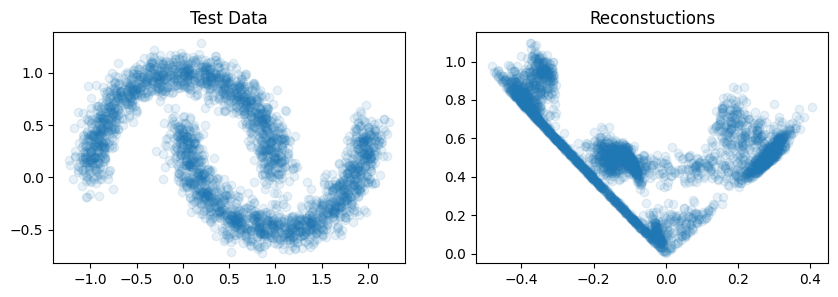

In [5]:
(means, _), _, _ = coix.traced_evaluate(inference_program, seed=0)(
    params, x=data_test
)

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.title("Test Data")
plt.scatter(*data_test.T, alpha=0.1)
plt.subplot(122)
plt.title("Reconstuctions")
plt.scatter(*means.T, alpha=0.1)

### Training

Unsurprisingly, the reconstructions of the untrained model do not resemble the test data. So let's train our neural networks. 
We first need to re-compose our inference program in a training context by providing a loss function via the `loss_fn` keyword argument (note that we also changed the surrounding particle plate, i.e. the number of samples, to match our batch size). In this context, every time a propose combinator is executed it additionally evaluates the provided loss function (here the ELBO) for the corresponding importance sampling step. The loss is consecutively stored in the metrics dictionary. Once we computed the loss all we have to do is to differentiate it w.r.t. the parameters of the encoder- and decoder- network and run our favorite gradient descent scheme. 

In [6]:
import numpy as np
import optax

n_batch = 300
_, inference_program = make_target_and_inference_program(
    *programs, num_particles=n_batch, loss_fn=coix.loss.elbo_loss
)


def loss_fn(rng_key, params, data):
  _, _, metrics = coix.traced_evaluate(inference_program, seed=rng_key)(
      params, x=data
  )
  return metrics["loss"]


optimizer = optax.adam(1e-2)
opt_state = optimizer.init(params)

rng_key = jax.random.PRNGKey(0)


def step(step, params, opt_state, data):
  step_key = jax.random.fold_in(rng_key, step)
  batch_key, loss_key = jax.random.split(step_key, 2)
  batch = jax.random.choice(batch_key, data, (n_batch,))
  value, grads = jax.value_and_grad(loss_fn, argnums=1)(loss_key, params, batch)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return value, params, opt_state


losses = []
for i in range(100):
  loss, params, opt_state = step(i, params, opt_state, data_train)
  losses.append(loss)
  if i % 10 == 0:
    print(f"Interation {i}: Loss {loss}")
losses = np.stack(losses)

Interation 0: Loss 11.543140411376953
Interation 10: Loss 10.440986633300781
Interation 20: Loss 10.183518409729004
Interation 30: Loss 10.072854042053223
Interation 40: Loss 10.193990707397461
Interation 50: Loss 10.157108306884766
Interation 60: Loss 10.007824897766113
Interation 70: Loss 10.13175106048584
Interation 80: Loss 10.030741691589355
Interation 90: Loss 10.185990333557129


Finally, let's plot the loss and means of our reconstructions and see if it worked. 

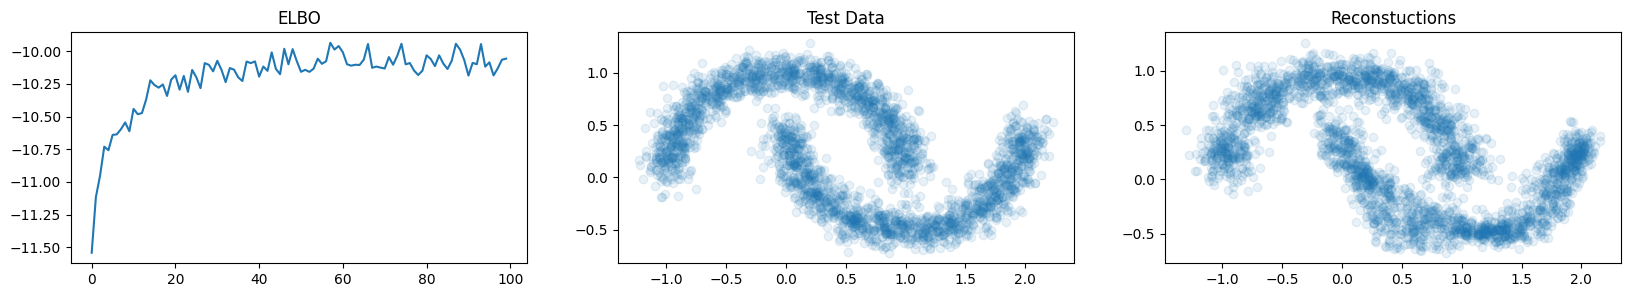

In [7]:
_, inference_program = make_target_and_inference_program(
    *programs, num_particles=n_test
)

plt.figure(figsize=(20, 3))
plt.subplot(131)
plt.title("ELBO")
plt.plot(-losses)
plt.subplot(132)
plt.title("Test Data")
plt.scatter(*data_test.T, alpha=0.1)
out, trace, metrics = coix.traced_evaluate(inference_program, seed=0)(
    params, x=data_test
)
means, _ = out
plt.subplot(133)
plt.title("Reconstuctions")
plt.scatter(*means.T, alpha=0.1)

While using coix to composing probabilitic programs to train a VAE is great for building some intuition on what inference combinators can be use for, there is not really much of a gain in term of code complexity or readability compared to a standard VAE implementation. The advantages of using coix really start to show once we try to implement more advances inference algorithms, e.g. variational annealing (see [tutorial part 3](./tutorial_part3_smcs.ipynb)). But before we dive into implementing more complex algorithms we are going to cover the coid API and some of the semantics in more details in [tutorial part 2](./tutorial_part2_api.ipynb).